# Regression in Python

## Dataset- Big Tech Stock Prices

By- Likith Kumar Dundigalla

#### To ignore warnings 

In [1]:
import warnings
warnings.filterwarnings("ignore")  

#### Import all required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#### Loading dataset into dataframe through Url

In [3]:
data=pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-02-07/big_tech_stock_prices.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45088 entries, 0 to 45087
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stock_symbol  45088 non-null  object 
 1   date          45088 non-null  object 
 2   open          45088 non-null  float64
 3   high          45088 non-null  float64
 4   low           45088 non-null  float64
 5   close         45088 non-null  float64
 6   adj_close     45088 non-null  float64
 7   volume        45088 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
data.describe()

,open,high,low,close,adj_close,volume
count,45088.000000,45088.000000,45088.000000,45088.000000,45088.000000,4.508800e+04
mean,89.266584,90.369825,88.111930,89.271306,85.209631,5.297813e+07
std,101.626955,103.001073,100.124399,101.592916,100.995967,9.324730e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,5.892000e+05
25%,25.670000,25.930135,25.360001,25.660000,22.076433,9.629425e+06
50%,47.930000,48.459999,47.465000,47.970001,45.377333,2.646315e+07
75%,128.662502,129.848900,127.253945,128.640609,113.672460,5.839768e+07
max,696.280029,700.989990,686.090027,691.690002,691.690002,1.880998e+09


In [6]:
data.isnull().sum()

stock_symbol    0
date            0
open            0
high            0
low             0
close           0
adj_close       0
volume          0
dtype: int64

In [7]:
data.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
0,AAPL,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,AAPL,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,AAPL,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,AAPL,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,AAPL,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [8]:
numeric_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

In [9]:
mean(data)

open         8.926658e+01
high         9.036983e+01
low          8.811193e+01
close        8.927131e+01
adj_close    8.520963e+01
volume       5.297813e+07
dtype: float64

In [10]:
std(data)

open         1.016258e+02
high         1.029999e+02
low          1.001233e+02
close        1.015918e+02
adj_close    1.009948e+02
volume       9.324626e+07
dtype: float64

<Axes: >

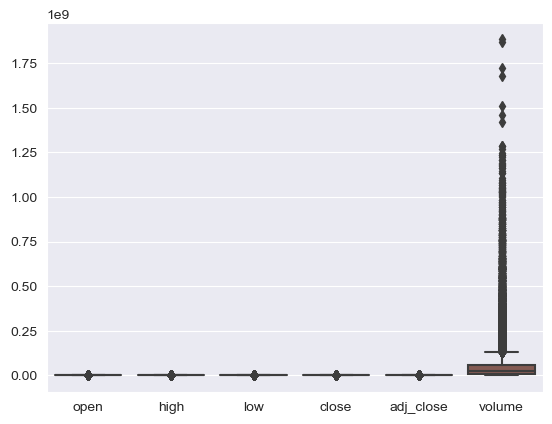

In [11]:
sns.boxplot(data)

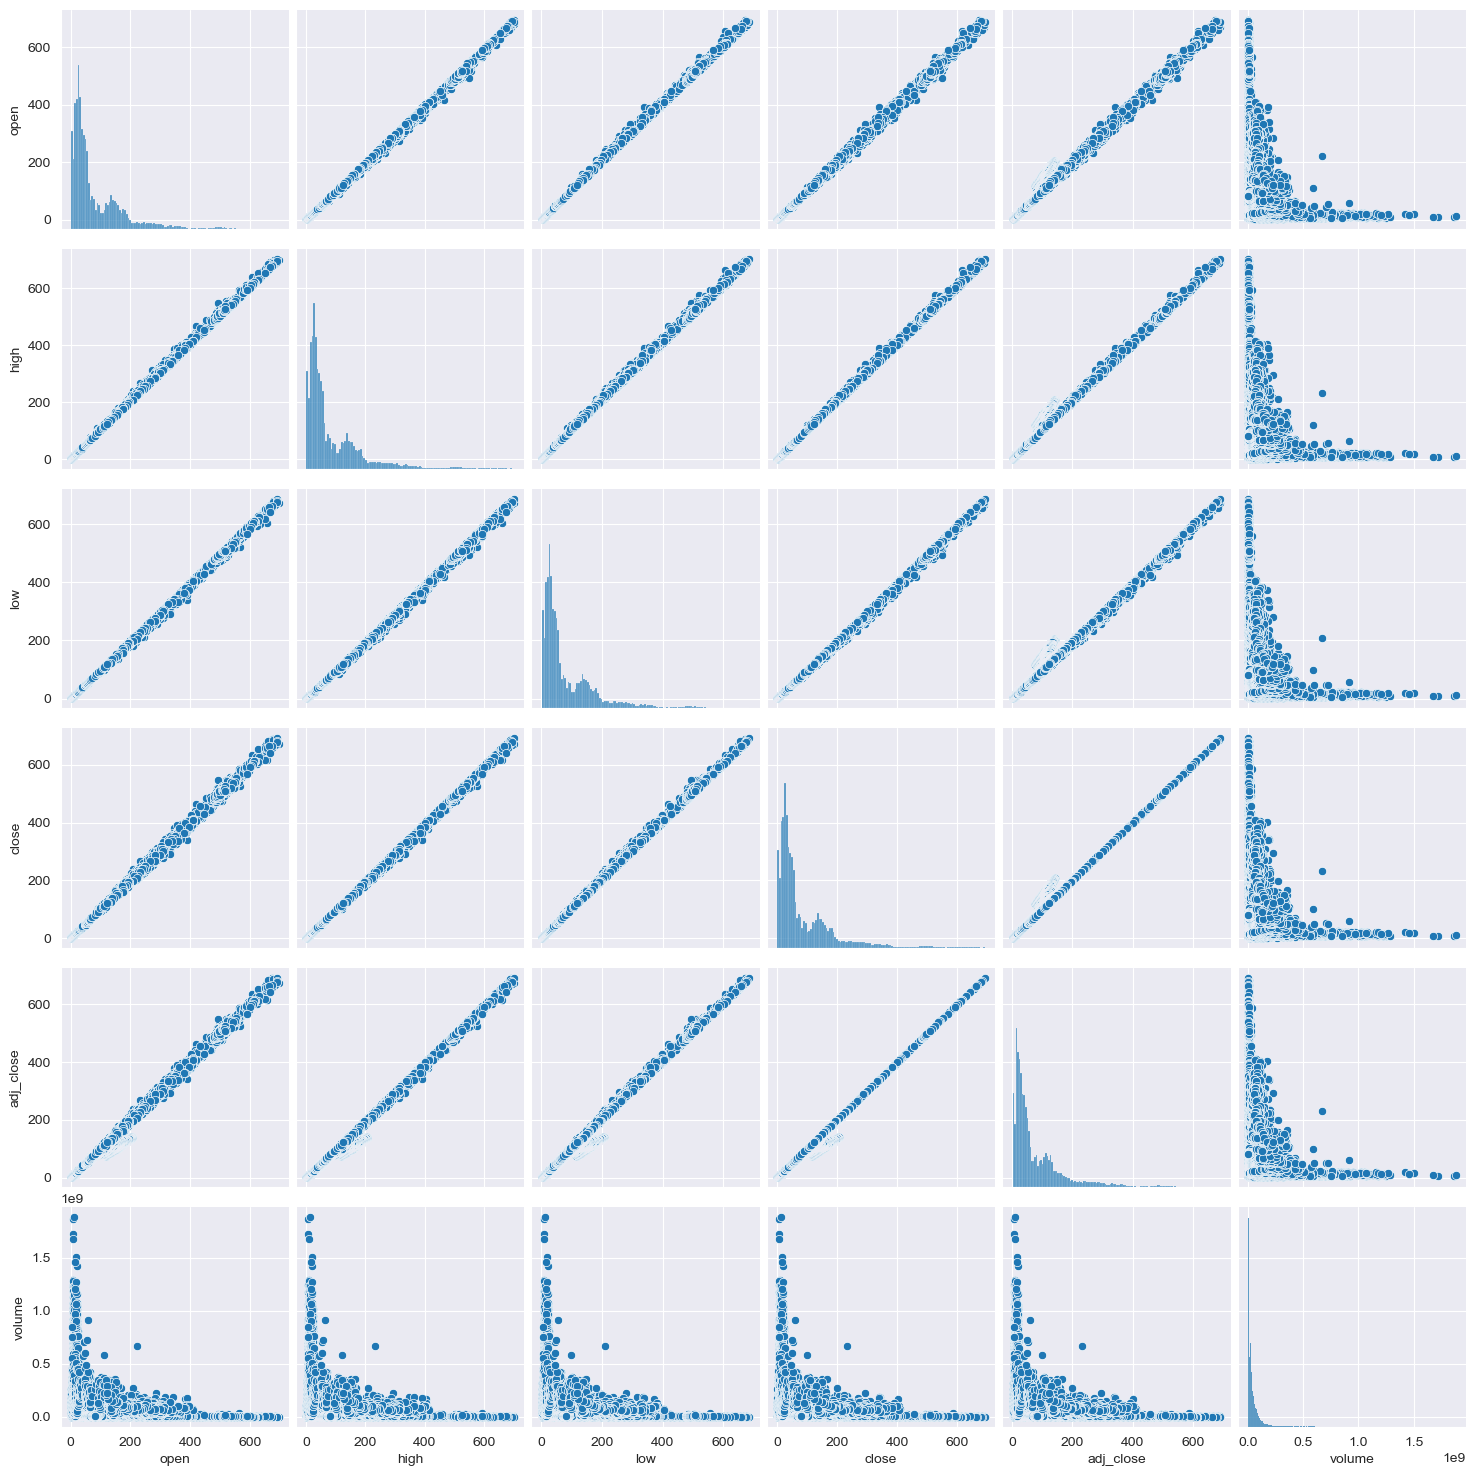

In [12]:
sns.pairplot(data,kind='scatter')

In [13]:
correlation_matrix = data.corr()
correlation_matrix

,open,high,low,close,adj_close,volume
open,1.000000,0.999856,0.999827,0.999677,0.994481,-0.224519
high,0.999856,1.000000,0.999761,0.999837,0.994871,-0.223344
low,0.999827,0.999761,1.000000,0.999841,0.994350,-0.226070
close,0.999677,0.999837,0.999841,1.000000,0.994783,-0.224695
adj_close,0.994481,0.994871,0.994350,0.994783,1.000000,-0.213404
volume,-0.224519,-0.223344,-0.226070,-0.224695,-0.213404,1.000000


In [14]:
X=data[['open']]
y=data['adj_close']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Resampling (if needed)
# Example: Resampling for imbalanced data using bootstrap
X_train_resampled, y_train_resampled = resample(X_train, y_train, replace=True, random_state=42)


In [20]:
# Model Building with statsmodels
X_train_sm = sm.add_constant(X_train_resampled)  
# Adding a constant for the intercept
ols_model = sm.OLS(y_train_resampled, X_train_sm).fit()
# Evaluate Model Performance
X_test_sm = sm.add_constant(X_test)  # Adding a constant for the intercept in test data (statsmodels)

# Predict using statsmodels model
y_pred_sm = ols_model.predict(X_test_sm)

# Model Diagnostics
#print(ols_model.summary())  # Print model summary with regression diagnostics

In [18]:
# Create linear regression object
lr_model = LinearRegression()
lr_model.fit(X_train_resampled, y_train_resampled)


X_test_lr = X_test  # No need to add constant for scikit-learn model


# Predict using scikit-learn model
y_pred_lr = lr_model.predict(X_test_lr)


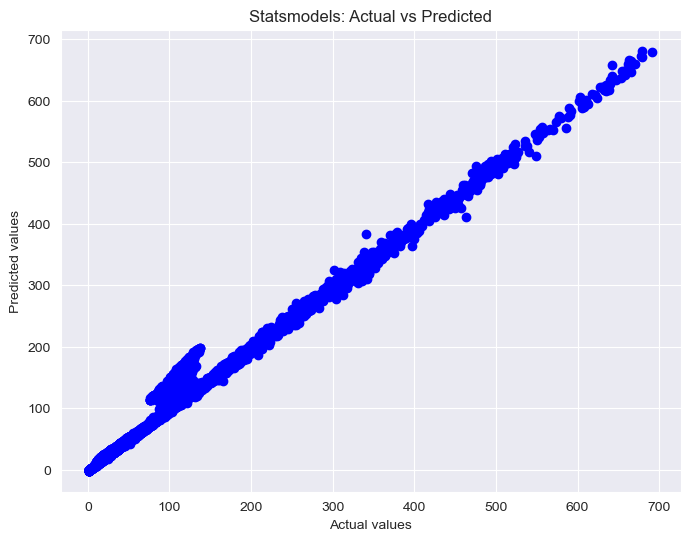

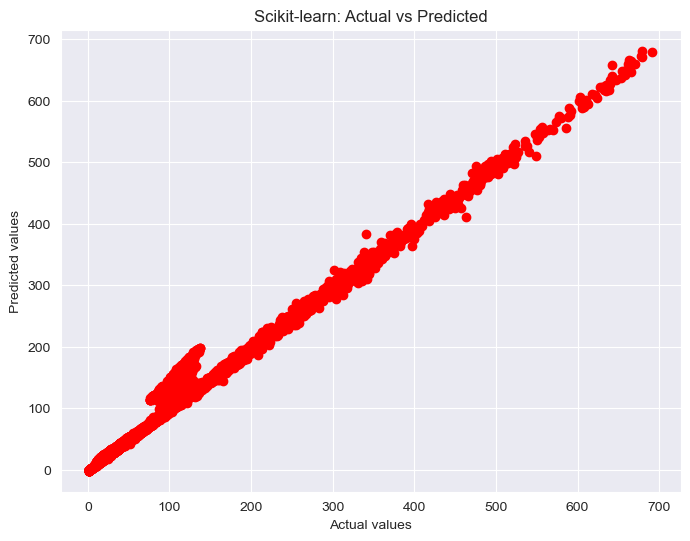

In [21]:
# Plotting for statsmodels model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_sm, color='blue')
plt.title('Statsmodels: Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

# Plotting for scikit-learn model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, color='red')
plt.title('Scikit-learn: Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


In [19]:
# Performance Metrics
print("Statsmodels R-squared:", r2_score(y_test, y_pred_sm)*100)
print("Scikit-learn R-squared:", r2_score(y_test, y_pred_lr)*100)


print("Statsmodels RMSE:", mean_squared_error(y_test, y_pred_sm, squared=False))
print("Scikit-learn RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))


print("Statsmodels MAE:", mean_absolute_error(y_test, y_pred_sm))
print("Scikit-learn MAE:", mean_absolute_error(y_test, y_pred_lr))


Statsmodels R-squared: 98.93700872669983
Scikit-learn R-squared: 98.93700872669983
Statsmodels RMSE: 10.647800281703317
Scikit-learn RMSE: 10.647800281703315
Statsmodels MAE: 5.451823616253067
Scikit-learn MAE: 5.451823616253058
